<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE40455-2020](https://jckantor.github.io/CBE40455-2020);
content is available [on Github](https://github.com/jckantor/CBE40455-2020.git).*


<!--NAVIGATION-->
< [3.2 Introduction to Simpy](https://jckantor.github.io/CBE40455-2020/03.02-Introduction-to-Simpy.html) | [Contents](toc.html) | [3.4 Modeling Events](https://jckantor.github.io/CBE40455-2020/03.04-Modeling-Events.html)<p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/03.03-Agent-Based-Models.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/03.03-Agent-Based-Models.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.3 Agent Based Models

In [1]:
!pip install simpy

## 3.3.1 Simpy: What we have learned so far

* Simpy provides a simulation environment that manages discrete-event simulations
* Use Python generators to model behavior of components of a larger system.
* Register instances of generators with the simulation environment
* Append "who, what, value" to a data log for post-processing 


What we will learn in this unit:

* Modeling multiple units
* Modeling a shared resource
* Extracting data from a data log


## 3.3.2 Example: A room full of Roombas

Let's imagine a large facility that is being cleaned by a collection of Roomba-type robotic cleaning units.  Each unit is characterized by time required to charge, and an amount of time it can clean before needing to be recharged. The facility must be cleaned during a 16 hour overnight shift. On average, 3 units must be operating continuously to meet the cleaning requirements, i.e., 3 x 16 = 48 hours machine cleaning each night. We would like to determine how many charging stations will be required.

| Unit | Charge Time (hrs) | Clean Time (hrs) |
| :--: | :--: | :--: |
| A | 1.0 | 2.5 |
| B | 0.5 | 1.5 |
| C | 0.8 | 2.0 |
| D | 1.4 | 3.5 |
| E | 0.5 | 1.2 |

![roomba](https://upload.wikimedia.org/wikipedia/commons/2/27/%D0%A0%D0%BE%D0%B1%D0%BE%D1%82_%D0%BF%D1%8B%D0%BB%D0%B5%D1%81%D0%BE%D1%81_Roomba_780.jpg)

In [2]:
import pandas as pd

roomba_data = [
    ["A", 1.0, 2.5],
    ["B", 0.5, 1.5],
    ["C", 0.8, 2.0],
    ["D", 1.4, 3.5],
    ["E", 0.5, 1.2],
]

roomba_df = pd.DataFrame(roomba_data, columns=["id", "charge_time", "clean_time"])
roomba_df

,id,charge_time,clean_time
0,A,1.0,2.5
1,B,0.5,1.5
2,C,0.8,2.0
3,D,1.4,3.5
4,E,0.5,1.2


## 3.3.3 One Roomba

The first challenge is to model the performance of a single Roomba. Our first attempt at a model consists of a simple Python generator. The data log consists of start and finish of each charge and cleaning cycle. For this first attempt, we'll assume a charging station is always available when needed, and we'll create just one instance of a Roomba to get started.

In [3]:
import simpy 
import pandas as pd

# create an empty data log
data_log = []

# roomba model is encapsulated as a Python generator. The id, charge_time, and clean_time
# parameters are the information needed to specify a particular instance of a Roomba.
# The model will log the begin and end of each charge and clean cycle
def roomba_model(id, charge_time, clean_time):
    while True:
        tic = env.now
        yield env.timeout(charge_time)
        toc = env.now
        data_log.append([id, "charging", tic, toc])
   
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])

# create the simulation environment
env = simpy.Environment()

# create the processes being simuulated
roomba = roomba_model("A", 1.0, 2.5)
env.process(roomba)

# run the simulation
env.run(until=16)

# convert the data_log to a Pandas DataFrame and display
df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
display(df)

,id,event,begin,end
0,A,charging,0.0,1.0
1,A,cleaning,1.0,3.5
2,A,charging,3.5,4.5
3,A,cleaning,4.5,7.0
4,A,charging,7.0,8.0
5,A,cleaning,8.0,10.5
6,A,charging,10.5,11.5
7,A,cleaning,11.5,14.0
8,A,charging,14.0,15.0


## 3.3.4 Adding a full complement of Roombas

The next step is to include all of the available Roombas to the simulation. We do this by looping over the data set that describes the available devices. For each interation, an instance of the Roomba model is created and an associated process added to the simulation environment.

In [4]:
import simpy 
import pandas as pd

data_log = []

def roomba_model(id, charge_time, clean_time):
    while True:
        tic = env.now
        yield env.timeout(charge_time)
        toc = env.now
        data_log.append([id, "charging", tic, toc])
   
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])
        
env = simpy.Environment()

for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))

env.run(until=16)
df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
display(df)

,id,event,begin,end
0,B,charging,0.0,0.5
1,E,charging,0.0,0.5
2,C,charging,0.0,0.8
3,A,charging,0.0,1.0
4,D,charging,0.0,1.4
5,E,cleaning,0.5,1.7
6,B,cleaning,0.5,2.0
7,E,charging,1.7,2.2
8,B,charging,2.0,2.5
9,C,cleaning,0.8,2.8


## 3.3.5 Extracting data from data logs

As we can see, one property of discrete-event simulations is that they can produce voluminous amounts of data. Direct examination of the data log is generally difficult, and not well suited to measuring system performance. In this section we demonstrate several methods for processing the data log to determine if the performance target of 48 cleaning hours is being acheived.

### 3.3.5.1 Writing your own methods

In [5]:
# get a sorted list of unique roomba names. This is extracted from the data log
roombas = list(set(df["id"]))
roombas.sort()

# total charge time
total_charge_time = 0.0
for r in roombas:
    idx = (df["id"]==r) & (df["event"]=="charging")
    dt = df[idx]["end"] - df[idx]["begin"]
    total_charge_time += sum(dt)

# total clean time
total_clean_time = 0.0
for r in roombas:
    idx = (df["id"]==r) & (df["event"]=="cleaning")
    dt = df[idx]["end"] - df[idx]["begin"]
    total_clean_time  += sum(dt)

print("total charge time =", total_charge_time)
print("total clean time =", total_clean_time)

total charge time = 23.0
total clean time = 51.8


### 3.3.5.2 Cut and Paste into Google Sheets

Cut and paste the data log into a Google Sheet. Use the pivot table feature to compute the total charge and total cleam times.

### 3.3.5.3 Using Pandas pivot tables

The Pandas library includes an extraordinarily useful `pivot_table()` function that can be used to process many different kinds of data that would normally be displayed as spreadsheets. The following cell demonstrates the use of `pivot_table()` to compute the total charging and cleaning time found in the simulation.

In [6]:
# import numpy to gain access to a sum function
import numpy as np

# add a new column to the DataFrame computing the desired data
df["time"] = df["end"] - df["begin"]

# create a pivot table that sums up the time spent on each event type.
pd.pivot_table(df, index=["event"], values="time", aggfunc={"time":np.sum} )

,time
event,
charging,23.0
cleaning,51.8


## 3.3.6 Introducing shared resources

A charging station is an example of a **shared resource**. There are three types of resources that can be modeled in Simpy:

* **Resource** Resources that can only used by a limited number of processes at a time.
* **Stores** Resources that can store or release Python objects.
* **Containers** Resources that model the production and consumption of bulk goods.

In this example, charging stations are an example of `Resources`. 

## 3.3.7 Charging stations as shared resources

The next cell shows how a charging station can be incorporated into the simulation as a shared resource. Three changes required:

* Create a simply.Resource() by specifying the simulation environment and resource capacity. 
* The Roomba model must create request for use of a charger. The request is specified in a subsequent `yield` statement. Execution resumes once a charger becomes available.
* When finished with a charger, the model must release the charger so that it is available for use in other model instances.

The following cell implements charger system with a capacity of 1. Examine the data log to verify that only one Roomba is charging at any point in time.

In [7]:
import simpy 
import pandas as pd

data_log = []

def roomba_model(id, charge_time, clean_time):
    while True:
        request = chargers.request()
        yield request
        tic = env.now
        yield env.timeout(charge_time)
        chargers.release(request)
        toc = env.now
        data_log.append([id, "charging", tic, toc])
   
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])
        
env = simpy.Environment()
chargers = simpy.Resource(env, capacity=1)

for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))

env.run(until=16)
df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])
display(df)

,id,event,begin,end
0,A,charging,0.0,1.0
1,B,charging,1.0,1.5
2,C,charging,1.5,2.3
3,B,cleaning,1.5,3.0
4,A,cleaning,1.0,3.5
5,D,charging,2.3,3.7
6,E,charging,3.7,4.2
7,C,cleaning,2.3,4.3
8,B,charging,4.2,4.7
9,E,cleaning,4.2,5.4


## 3.3.8 How many charging stations are required?

The following cell uses the Python `with` statement to request a changer and release it upon completion of a code block. The advantage of this construction is that it handles the release automatically, thereby avoiding a potential source of coding errors, and also provides a visual demarcation of the code block where the charger is being use.

The cell also uses the Pandas `pivot_table` to report the total amount of charging used and cleaning time provided. Find the minimum number of chargers required to produce 48 hours of cleaning time in a 16 hour shift.

In [8]:
import simpy 
import pandas as pd
import numpy as np

data_log = []

def roomba_model(id, charge_time, clean_time):
    while True:
        with chargers.request() as request:
            yield request
            tic = env.now
            yield env.timeout(charge_time)
            toc = env.now
            data_log.append([id, "charging", tic, toc])
            
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])
        
env = simpy.Environment()
chargers = simpy.Resource(env, capacity=1)

for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))

env.run(until=16)
df = pd.DataFrame(data_log, columns=["id", "event", "begin", "end"])

df["time"] = df["end"] - df["begin"]
pd.pivot_table(df, index=["event"], values="time", aggfunc={"time":np.sum} )

,time
event,
charging,15.4
cleaning,31.3


## 3.3.9 Assignment for Thursday

### 3.3.9.1 Exercise 1. 

Answer the question posed above: How many charging stations are needed to provide 48 hours cleaning services in the overnight shift?

### 3.3.9.2 Exercise 2.

Modify the model to assume the changers are fully charged at the start of the cleaning shift. Does that reduce the number of chargers required?

### 3.3.9.3 Exercise 3.

Assume each Roomba needs to dispose of waste after 20 minutes of cleaning, that it takes 5 minutes to dispose of the waste, and requires access to a waste disposal station. 

Hints:
* You will need to create a log a new event called 'waste disposal'. 
* Model the waste disposal station as a shared resource.
* You may need to make some decisions on how to handle the waste at the end of a cleaning cycle. Don't get too bogged down, just make some reasonable assumptions. We'll address this issue in the next class. 

### 3.3.9.4 Exercise 4. (optional)

Create a function that accepts df (the data log after converting to a pandas DataFrame) and, for every Roomba, shows a time line of events.

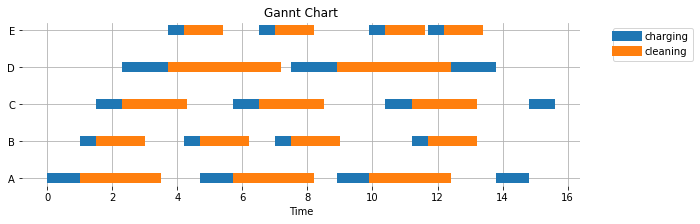

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def gantt(df, lw=10):
    
    # create sorted lists of the unique ids and events appearing in the data log
    ids = sorted(list(set(df["id"])))
    events = sorted(list(set(df["event"])))
    
    # create list of unique colors for each event
    colors = [f"C{i}" for i in range(len(events))]
    
    # create plot window
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    
    # for each event and id, find entries in the data log and plot the begin and end points
    for i, event in enumerate(events):
        for j, id in enumerate(ids):  
            for k in df[(df["id"]==id) & (df["event"]==event)].index:
                ax.plot([df["begin"][k], df["end"][k]], [j, j], colors[i], solid_capstyle="butt", lw=lw)
                
    # create legend
    lines = [Line2D([0], [0], lw=lw, color=colors[i]) for i in range(len(events))]
    ax.legend(lines, events, bbox_to_anchor=(1.05, 1.0), loc="upper left")
    
    # annotate the axes
    ax.set_yticks(range(len(ids)))
    ax.set_yticklabels(ids)
    ax.grid(True)
    ax.set_xlabel("Time")
    ax.set_title("Gannt Chart")
    for sp in ['top', 'bottom', 'right', 'left']:
        ax.spines[sp].set_visible(False)
        
gantt(df)

<!--NAVIGATION-->
< [3.2 Introduction to Simpy](https://jckantor.github.io/CBE40455-2020/03.02-Introduction-to-Simpy.html) | [Contents](toc.html) | [3.4 Modeling Events](https://jckantor.github.io/CBE40455-2020/03.04-Modeling-Events.html)<p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/03.03-Agent-Based-Models.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/03.03-Agent-Based-Models.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>